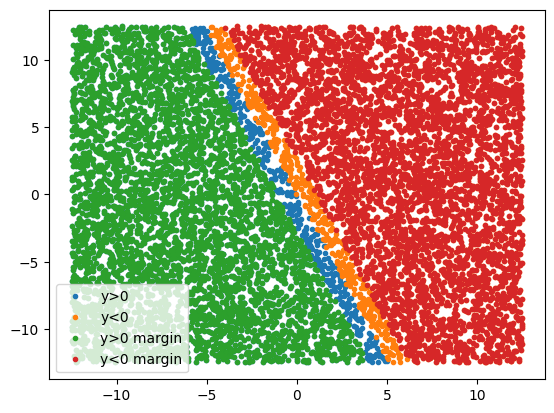

pre and post train accuracies: 0.393 and 0.971


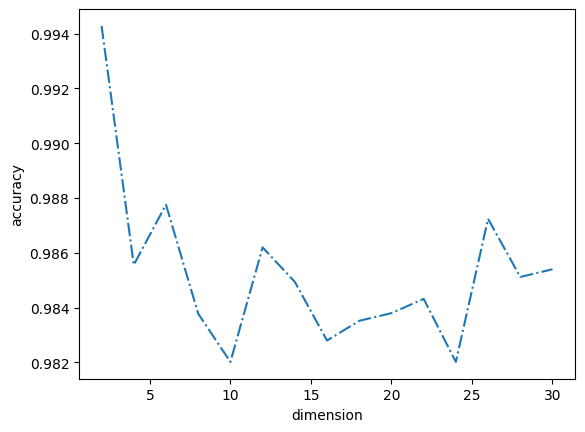

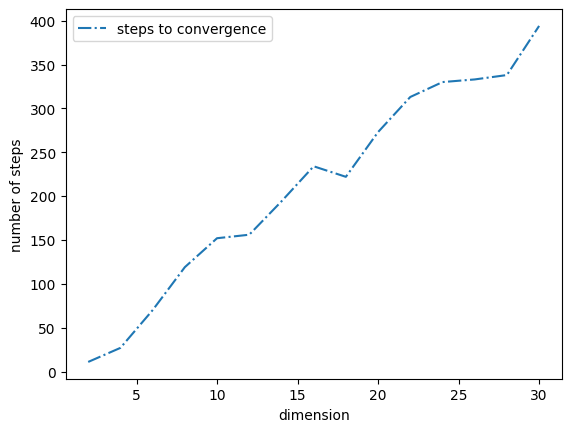

In [5]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt


class DataGen:
    def __init__(self, dim=10):
        w = np.random.random(dim) - .5
        w /= la.norm(w)
        self.dim = dim
        self.w = w

    def gen_data(self, n_data=10000):
        x_data = 25 * (np.random.random([self.dim, n_data]) - .5)
        y_data = np.sign(self.w @ x_data)
        return x_data, y_data

    def filter_data(self, x, y):
        g_idx = (y * (self.w @ x)) >= 1
        return x[:, g_idx], y[g_idx]

    def gen_marg_data(self, n_data=10000):
        x, y = self.gen_data(n_data=n_data)
        xf, yf = self.filter_data(x, y)
        return xf, yf

    def get_truth(self):
        return self.w


class Perceptron:
    def __init__(self, dim=10):
        w = np.random.random(dim) - .5
        w /= la.norm(w)
        self.w = w
        self.dim = dim

    def get_wrongs(self, x_data, y_data):

        idx_wrongs = self.w @ x_data * y_data < 0
        x_data_wrongs = x_data[:, idx_wrongs]
        y_data_wrongs = y_data[idx_wrongs]
        num_wrongs = len(y_data_wrongs)

        return num_wrongs, x_data_wrongs, y_data_wrongs

    def fit_w(self, x_data, y_data, printing = False):

        num_wrongs, x_wrongs, y_wrongs = self.get_wrongs(x_data, y_data)

        iter = 0
        while num_wrongs > 0:

            idx = np.random.randint(num_wrongs)
            w = self.w + x_wrongs[:, idx]*y_wrongs[idx]
            self.w = w
            num_wrongs, x_wrongs, y_wrongs = self.get_wrongs(x_data, y_data)

            if printing:
                if iter % 100 == 0:
                    print(f"iteration {iter}, and wrongs {num_wrongs}")
            iter += 1

        bound = (la.norm(self.w) * la.norm(x_data, axis=0).max()) ** 2

        return None

    def eval_w(self, x_test, y_test):

        num_wrongs, _, _ = self.get_wrongs(x_test, y_test)
        acc = (y_test.shape[0] - num_wrongs) / y_test.shape[0]
        
        return float(acc)


def plot_2D(n=1000, show=True):
    plt.clf()
    dg2 = DataGen(dim=2)
    x, y = dg2.gen_data(n_data=n)
    xf, yf = dg2.filter_data(x, y)
    p_idx = y > 0
    p_idx_fil = yf > 0
    plt.plot(x[0, p_idx], x[1, p_idx], '.', label='y>0')
    plt.plot(x[0, ~p_idx], x[1, ~p_idx], '.', label='y<0')
    plt.plot(xf[0, p_idx_fil], xf[1, p_idx_fil], '.', label='y>0 margin')
    plt.plot(xf[0, ~p_idx_fil], xf[1, ~p_idx_fil], '.', label='y<0 margin')
    plt.legend()
    if show:
        plt.show()


def one_run(n=10000, dim=10):
    dg = DataGen(dim=dim)
    x, y = dg.gen_marg_data(n_data=n)
    x_test, y_test = dg.gen_data(n_data=n)
    perceptron = Perceptron(dim=dim)
    pre_tr_acc = perceptron.eval_w(x_test, y_test)
    perceptron.fit_w(x, y)
    post_tr_acc = perceptron.eval_w(x_test, y_test)
    print(f"pre and post train accuracies: {pre_tr_acc:.3f} and {post_tr_acc:.3f}")


def many_runs(n=50000, dims=np.linspace(2, 30, 15).astype(int)):
    data = np.zeros([4, dims.shape[0]])
    j = 0
    for dim in dims:
        dg = DataGen(dim=dim)
        x, y = dg.gen_marg_data(n_data=n)
        assert x.shape[1] > 0, "not enough data!"
        xt, yt = dg.gen_data(n_data=n)
        perceptron = Perceptron(dim=dim)
        n_steps, upper_bound = perceptron.fit_w(x, y, printing=False)
        accuracy = perceptron.eval_w(xt, yt)
        data[:, j] = np.array([dim, n_steps, upper_bound, accuracy])
        j += 1
    plt.figure(1)
    plt.plot(data[0, :], data[3, :], '-.')
    plt.xlabel('dimension')
    plt.ylabel('accuracy')
    plt.figure(2)
    plt.plot(data[0, :], data[1, :], '-.', label='steps to convergence')
    plt.legend()
    plt.xlabel('dimension')
    plt.ylabel('number of steps')
    plt.show()


if __name__ == "__main__":
    # Step 1: visualize data
    plot_2D(n=10000)

    # Step 2: Check instance performance of model
    one_run(n=1000)

    # Step 3: Check complexity, empirically
    many_runs()
